In [0]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip  -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 14:14:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 2404:6800:4003:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  85.0MB/s    in 0.8s    

2019-04-18 14:14:51 (85.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Problem 1

In [0]:

import os
import zipfile

from keras.applications.vgg19 import VGG19

from keras import layers
from keras import models
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.models import load_model

import numpy as np
import pickle
import matplotlib.pyplot as plt

In [0]:


local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 7s 0us/step


In [0]:
model = models.Sequential()
# Start from VGG19
model.add(conv_base)
# Add my custom classifier
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [0]:
def lr_scheduler(epoch):
  lr = 1e-4
  if epoch >= 50:
      lr = 5e-6
  elif epoch >= 40:
      lr = 2e-5
  elif epoch >= 30:
      lr = 4e-5
  elif epoch >= 20:
      lr = 6e-5
  elif epoch >= 10:
      lr = 8e-5
  print('Learning rate: ', lr)
  return lr

In [0]:
# data augmentation of train set
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# only rescale for validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model 
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(), 
    metrics=['acc'])

#model check point
mc = ModelCheckpoint('best_model_p1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[LearningRateScheduler(lr_scheduler),mc]
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
Learning rate:  0.0001
100/100 [==============================] - 23s 232ms/step - loss: 0.6136 - acc: 0.6675 - val_loss: 0.5439 - val_acc: 0.7290

Epoch 00001: val_acc improved from -inf to 0.72900, saving model to best_model_p1.h5
Epoch 2/50
Learning rate:  0.0001
100/100 [==============================] - 19s 190ms/step - loss: 0.4884 - acc: 0.7535 - val_loss: 0.4060 - val_acc: 0.7950

Epoch 00002: val_acc improved from 0.72900 to 0.79500, saving model to best_model_p1.h5
Epoch 3/50
Learning rate:  0.0001
100/100 [==============================] - 18s 183ms/step - loss: 0.4641 - acc: 0.7795 - val_loss: 0.3767 - val_acc: 0.8130

Epoch 00003: val_acc improved from 0.79500 to 0.81300, saving model to best_model_p1.h5
Epoch 4/50
Learning rate:  0.0001
100/100 [==============================] - 18s 179ms/step - loss: 0.4393 - acc: 0.7925 - val_los

In [0]:
model.save('checkpoint_hw3_p1_final.h5')
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
h = (acc, val_acc, loss, val_loss)
# Save History
pickle.dump( h, open( "p1.hist", "wb" ) )

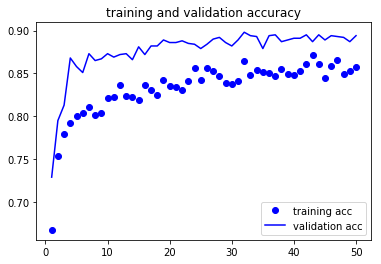

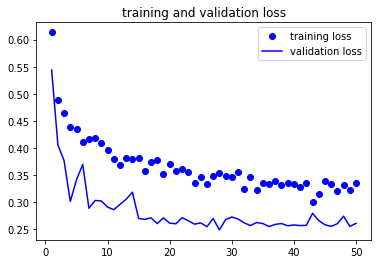

In [0]:

%matplotlib inline

(acc, val_acc, loss, val_loss) = pickle.load( open( "p1.hist", "rb" ) )
 
epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

Problem 2

In [0]:

from keras.models import load_model

# Deletes the existing model
del model  

# Load Model
model = load_model('best_model_p1.h5')
print(conv_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
conv_base.trainable = True
for layer in conv_base.layers:
  if layer.name == 'block5_conv4' or layer.name == 'block_conv3':
    layer.trainable = True
  else:
    layer.trainable = False
    
# compile model 
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(), 
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


In [0]:
#model check point
mc2 = ModelCheckpoint('best_model_p2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# train using the same scheduler but it start with a lower learning rate
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    initial_epoch= 50,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[LearningRateScheduler(lr_scheduler),mc2]
)

Epoch 51/100
Learning rate:  5e-06
100/100 [==============================] - 32s 316ms/step - loss: 0.3071 - acc: 0.8695 - val_loss: 0.2007 - val_acc: 0.9300

Epoch 00051: val_acc improved from -inf to 0.93000, saving model to best_model_p2.h5
Epoch 52/100
Learning rate:  5e-06
100/100 [==============================] - 26s 264ms/step - loss: 0.2452 - acc: 0.9065 - val_loss: 0.1750 - val_acc: 0.9450

Epoch 00052: val_acc improved from 0.93000 to 0.94500, saving model to best_model_p2.h5
Epoch 53/100
Learning rate:  5e-06
100/100 [==============================] - 26s 263ms/step - loss: 0.2116 - acc: 0.9180 - val_loss: 0.1250 - val_acc: 0.9580

Epoch 00053: val_acc improved from 0.94500 to 0.95800, saving model to best_model_p2.h5
Epoch 54/100
Learning rate:  5e-06
100/100 [==============================] - 26s 264ms/step - loss: 0.1874 - acc: 0.9210 - val_loss: 0.1194 - val_acc: 0.9570

Epoch 00054: val_acc did not improve from 0.95800
Epoch 55/100
Learning rate:  5e-06
100/100 [=====

In [0]:
model.save('checkpoint_hw3_p2_final.h5')
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
h = (acc, val_acc, loss, val_loss)
# Save History
pickle.dump( h, open( "p2.hist", "wb" ) )

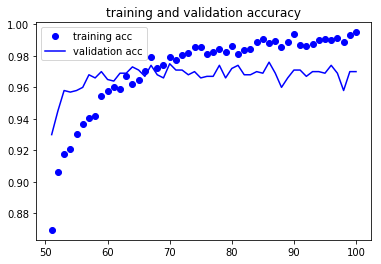

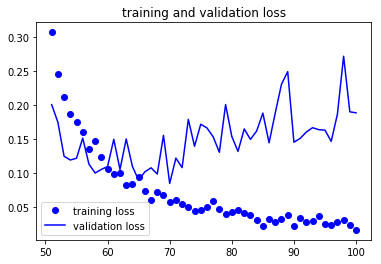

In [0]:
%matplotlib inline

(acc, val_acc, loss, val_loss) = pickle.load( open( "p2.hist", "rb" ) )

epochs = range(51, len(acc) + 51)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Val_acc:", val_acc,"Val_loss:", val_loss)
model.save('p2_final.h5')

Val_acc: 0.9619999921321869 Val_loss: 0.24379746708724157


Problem 3

In [1]:
from keras.applications.vgg19 import VGG19
model = VGG19(weights='imagenet')

last_conv_layer = model.get_layer('block5_conv4')
last_conv_layer_dim = last_conv_layer.output_shape
print(last_conv_layer)
print(last_conv_layer_dim)


from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
574717952/574710816 [==============================] - 17s 0us/step
(None, 14, 14, 512)


Saving cat.2497.jpg to cat.2497.jpg
Saving cat.2498.jpg to cat.2498.jpg
Saving cat.2499.jpg to cat.2499.jpg
Saving dog.2496.jpg to dog.2496.jpg
Saving dog.2497.jpg to dog.2497.jpg
Saving dog.2498.jpg to dog.2498.jpg
Saving dog.2499.jpg to dog.2499.jpg
User uploaded file "cat.2497.jpg" with length 21939 bytes
User uploaded file "cat.2498.jpg" with length 16485 bytes
User uploaded file "cat.2499.jpg" with length 21451 bytes
User uploaded file "dog.2496.jpg" with length 41870 bytes
User uploaded file "dog.2497.jpg" with length 36643 bytes
User uploaded file "dog.2498.jpg" with length 42856 bytes
User uploaded file "dog.2499.jpg" with length 51876 bytes


In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions

In [0]:
def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  # reduce size to fit window and display superimposed image
  cv2_imshow(cv2.resize(superimposed_img,(500, int(500/img.shape[1]*img.shape[0]))))

In [0]:
import traceback

def process_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #
  preds = model.predict(x)
  print('Predicted:', decode_predictions(preds, top=5)[0])
 
  # We are getting only the max propability match
  class_index = np.argmax(preds[0])
  # class_index = np.argsort(preds[0])[-(1+idx)] 

  class_output=model.output[:,class_index]

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  #
  show_superimposed_image(img_path, heatmap)

In [6]:

for fn in uploaded.keys():
  print('Visualize heatmaps for uploaded file "%s"'% fn)
  process_image(fn)

Output hidden; open in https://colab.research.google.com to view.

Problem4

In [0]:
# Deletes the existing model
del model 

# Load Model
model = load_model('best_model_p2.h5')
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
layer = model.get_layer('flatten_1')
layer_output = layer.output
activation_model = models.Model(input=model.input, outputs=[layer_output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("vg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
batch_size = 20
# only rescale for validation set
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
#  Since the batch is 20 we need 50 steps to go over the 1000 images
sample_count = 1000
images = np.zeros(shape=(sample_count, 150, 150, 3))
labels = np.zeros(shape=(sample_count),dtype=int)
i = 0
for input_batch, labels_batch in validation_generator:
  images[i * batch_size : (i + 1) * batch_size] = input_batch
  labels[i * batch_size : (i + 1) * batch_size] = labels_batch
  i += 1
  if i * batch_size >= sample_count:
    break
print(images.shape)
print(labels.shape)
print(images[0])
print(labels[0])

Found 1000 images belonging to 2 classes.
(1000, 150, 150, 3)
(1000,)
[[[0.52941179 0.43921572 0.3137255 ]
  [0.58039218 0.49019611 0.36470589]
  [0.59215689 0.49803925 0.36470589]
  ...
  [0.4039216  0.27843139 0.04705883]
  [0.3921569  0.26274511 0.05490196]
  [0.39607847 0.26274511 0.07450981]]

 [[0.58431375 0.50588238 0.37647063]
  [0.59215689 0.50196081 0.37647063]
  [0.63529414 0.5411765  0.40784317]
  ...
  [0.4039216  0.27843139 0.04705883]
  [0.40784317 0.27843139 0.06666667]
  [0.41960788 0.29019609 0.09019608]]

 [[0.59607846 0.51372552 0.3921569 ]
  [0.63529414 0.5529412  0.43137258]
  [0.65490198 0.56470591 0.43921572]
  ...
  [0.41568631 0.29019609 0.05882353]
  [0.43137258 0.3019608  0.09019608]
  [0.43529415 0.30588236 0.10588236]]

 ...

 [[0.57647061 0.44705886 0.18431373]
  [0.56862748 0.43921572 0.16862746]
  [0.58431375 0.45490199 0.18431373]
  ...
  [0.61960787 0.43921572 0.13725491]
  [0.61960787 0.43529415 0.12941177]
  [0.63921571 0.45490199 0.14117648]]

 [[0

In [0]:
activations = activation_model.predict(images)
print(activations.shape)
print(activations[0])

(1000, 8192)
[0.43017665 0.         0.         ... 0.         0.3739637  0.        ]


In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

In [0]:

from sklearn.manifold import TSNE
import time
time_start = time.time()
activations_tsne = TSNE(perplexity=35,verbose=2).fit_transform(activations,labels)
print('Activations t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.411s...
[t-SNE] Computed neighbors for 1000 samples in 20.954s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 8.692816
[t-SNE] Computed conditional probabilities in 0.077s
[t-SNE] Iteration 50: error = 75.7038422, gradient norm = 0.3142778 (50 iterations in 0.409s)
[t-SNE] Iteration 100: error = 76.8338165, gradient norm = 0.3020386 (50 iterations in 0.398s)
[t-SNE] Iteration 150: error = 77.8962555, gradient norm = 0.2744280 (50 iterations in 0.422s)
[t-SNE] Iteration 200: error = 79.5419006, gradient norm = 0.3007348 (50 iterations in 0.471s)
[t-SNE] Iteration 250: error = 79.7304153, gradient norm = 0.2687110 (50 iterations in 0.461s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.730415
[t-SNE] Iteration 300: error = 1.6139688, gradient norm = 0.0037842 (50 iterations in 0.479s)
[t-SNE] Iteration 350: error = 1.4715711, gradient norm = 0.001

{'cats': 0, 'dogs': 1}
['cats', 'dogs']


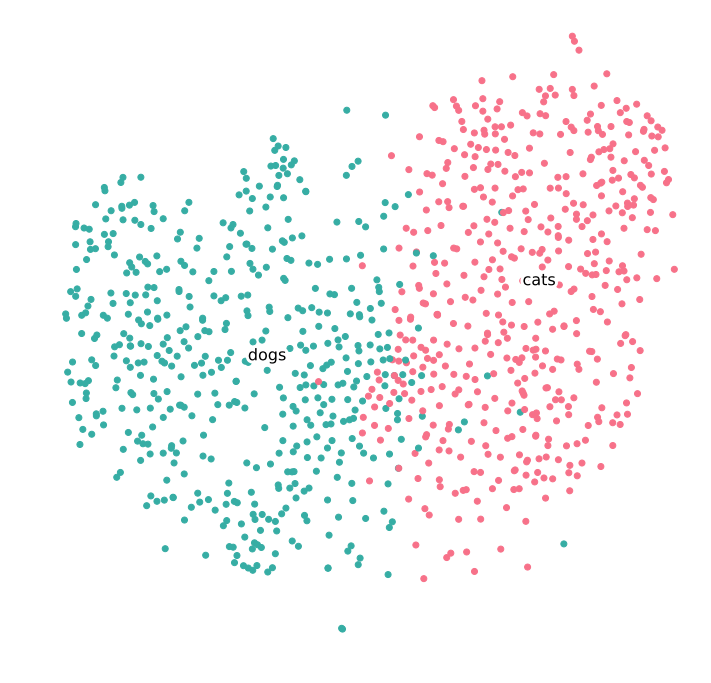

In [0]:
class_indices = validation_generator.class_indices
print(class_indices)
class_names = sorted(class_indices)
print(class_names)
data_scatter(activations_tsne, labels)

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 1000 samples in 2.520s...
[t-SNE] Computed neighbors for 1000 samples in 171.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 18.621550
[t-SNE] Computed conditional probabilities in 0.077s
[t-SNE] Iteration 50: error = 96.0318527, gradient norm = 0.3125981 (50 iterations in 0.460s)
[t-SNE] Iteration 100: error = 98.8913956, gradient norm = 0.2503099 (50 iterations in 0.426s)
[t-SNE] Iteration 150: error = 100.7826157, gradient norm = 0.2694065 (50 iterations in 0.437s)
[t-SNE] Iteration 200: error = 102.7303925, gradient norm = 0.2393655 (50 iterations in 0.482s)
[t-SNE] Iteration 250: error = 106.1392670, gradient norm = 0.2068412 (50 iterations in 0.498s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.139267
[t-SNE] Iteration 300: error = 2.6447814, gradient norm = 0.0056618 (50 iterations in 0.579s)
[t-SNE] Iteration 350: error = 2.2620673, gradient norm =

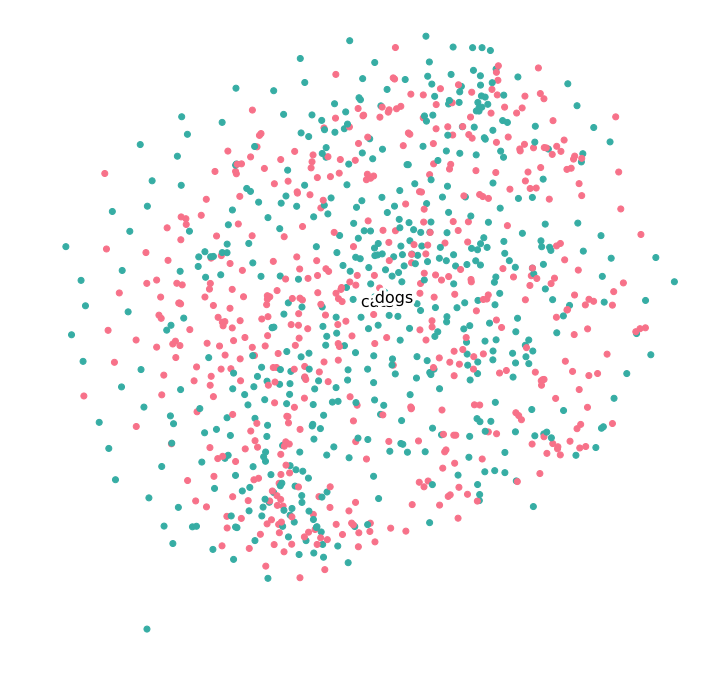

In [0]:
time_start = time.time()
input_tsne = TSNE(perplexity=35,verbose=2).fit_transform(np.reshape(images,(1000,150*150*3)))
print('Input Images t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))
data_scatter(input_tsne, labels)